In [1]:
import time
main_start = time.perf_counter()

import multiprocessing
import pandas as pd
import numpy as np
from datetime import datetime, date
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline
# from sklearn.model_selection import train_test_split

# from sklearn.model_selection import GridSearchCV
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression


In [2]:
# Read the data
train = pd.read_csv('./sales_train.csv')
test = pd.read_csv('./test.csv')
submission = pd.read_csv('./sample_submission.csv')
items = pd.read_csv('./items.csv')
item_cats = pd.read_csv('./item_categories.csv')
shops = pd.read_csv('./shops.csv')

In [3]:
train.loc[train['item_cnt_day']>900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [4]:
train = train[train.item_cnt_day<1000]
train.index[train.item_cnt_day>900]

Int64Index([], dtype='int64')

In [5]:
train = train[train.item_price<60000]
train.loc[train.item_price>60000]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [6]:
print("\nAre there any NaN values: ",train.isnull().values.any())


Are there any NaN values:  False


In [7]:
# train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

In [8]:
start = time.perf_counter()
processes = []
q = multiprocessing.Queue()
types = ['d','m','y']

def editDate(q,arg):
    obj = np.array(train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%'+arg)), dtype=np.int8)
    q.put([arg,obj])

for i in types:
    process=multiprocessing.Process(target=editDate, args=[q,i])
    process.start() 
    processes.append(process)

for _ in types:
    result = q.get()
    train[result[0]]=result[1]

for process in processes:
    process.join()

finish = time.perf_counter()

print(f'Finished in {round(finish-start, 2)} second(s)')

Finished in 48.28 second(s)


In [9]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,y,d,m
0,02.01.2013,0,59,22154,999.00,1.0,13,2,1
1,03.01.2013,0,25,2552,899.00,1.0,13,3,1
2,05.01.2013,0,25,2552,899.00,-1.0,13,5,1
3,06.01.2013,0,25,2554,1709.05,1.0,13,6,1
4,15.01.2013,0,25,2555,1099.00,1.0,13,15,1
...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,15,10,10
2935845,09.10.2015,33,25,7460,299.00,1.0,15,9,10
2935846,14.10.2015,33,25,7459,349.00,1.0,15,14,10
2935847,22.10.2015,33,25,7440,299.00,1.0,15,22,10


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


(<Figure size 1440x720 with 4 Axes>,
 array([<AxesSubplot:ylabel='2013'>, <AxesSubplot:ylabel='2014'>,
        <AxesSubplot:ylabel='2015'>], dtype=object))

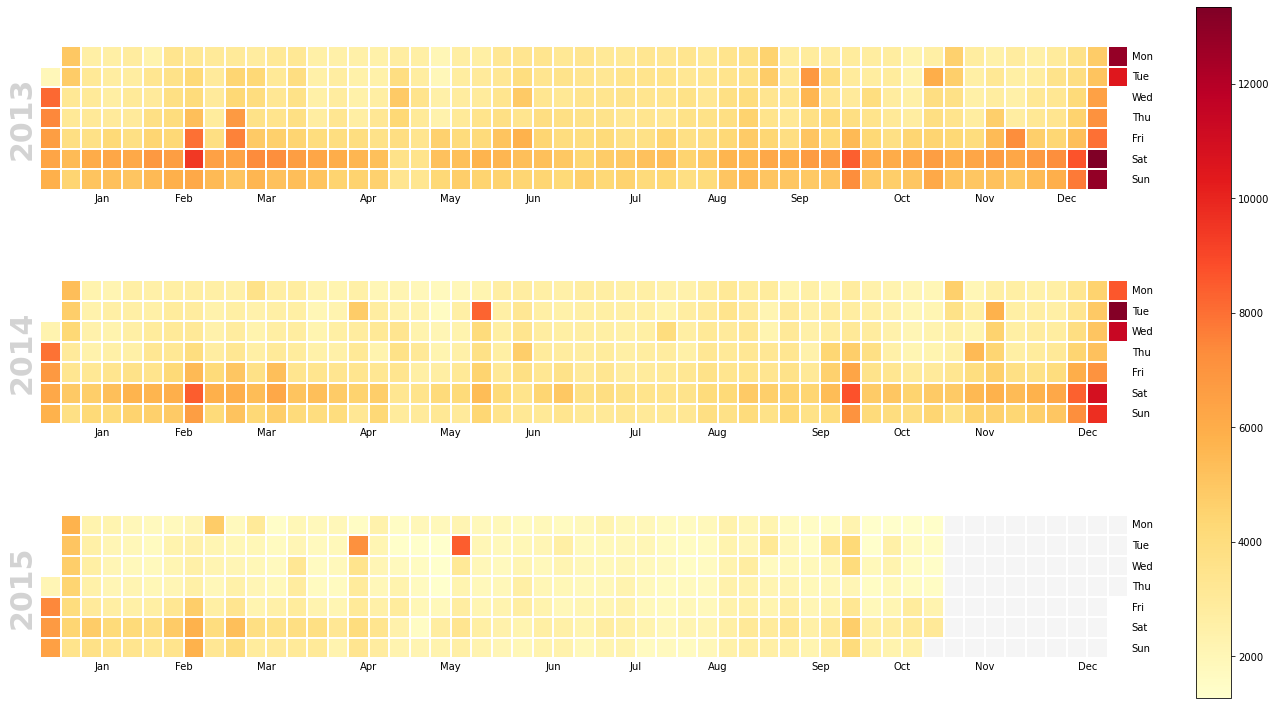

In [10]:
import calplot
df=[]
df = train
df = df.rename(columns={"date":"date1"})
df["date1"] = pd.to_datetime(df["date1"], format = "%d.%m.%Y")
df_calendar = df[["date1", "item_cnt_day"]]
# set date as index and resample
df_calendar.set_index("date1", inplace = True)
df.index = pd.to_datetime(df.index)
# notice that this time, we don't convert it to_frame()
# df_calendar is a pandas series
# THIS IS IMPORTANT since calmap expects a series
# with a datetime index and the values to plot
df_calendar = df_calendar.resample("D")["item_cnt_day"].sum()

# ----------------------------------------------------------------------------------------------------
# plot the data using calmap
calplot.calplot(df_calendar,cmap='YlOrRd', figsize=(20,10),yearcolor='lightgray')


In [11]:
train = train[:50000]
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,y,d,m
0,02.01.2013,0,59,22154,999.00,1.0,13,2,1
1,03.01.2013,0,25,2552,899.00,1.0,13,3,1
2,05.01.2013,0,25,2552,899.00,-1.0,13,5,1
3,06.01.2013,0,25,2554,1709.05,1.0,13,6,1
4,15.01.2013,0,25,2555,1099.00,1.0,13,15,1
...,...,...,...,...,...,...,...,...,...
49995,25.01.2013,0,18,16450,399.00,1.0,13,25,1
49996,10.01.2013,0,18,16460,199.00,1.0,13,10,1
49997,27.01.2013,0,18,16462,399.00,1.0,13,27,1
49998,30.01.2013,0,18,16482,399.00,1.0,13,30,1


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,y,d,m
0,02.01.2013,0,59,22154,999.00,1.0,13,2,1
1,03.01.2013,0,25,2552,899.00,1.0,13,3,1
2,05.01.2013,0,25,2552,899.00,-1.0,13,5,1
3,06.01.2013,0,25,2554,1709.05,1.0,13,6,1
4,15.01.2013,0,25,2555,1099.00,1.0,13,15,1
...,...,...,...,...,...,...,...,...,...
49995,25.01.2013,0,18,16450,399.00,1.0,13,25,1
49996,10.01.2013,0,18,16460,199.00,1.0,13,10,1
49997,27.01.2013,0,18,16462,399.00,1.0,13,27,1
49998,30.01.2013,0,18,16482,399.00,1.0,13,30,1


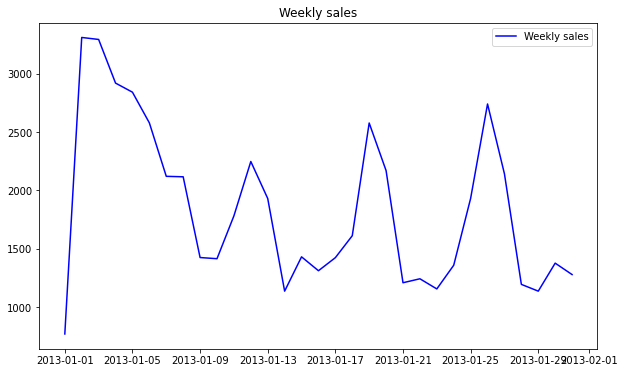

In [12]:
x=[]
df1 = train[:50000]
df1 = df1.rename(columns={"date":"date1"})
df1["date1"] = pd.to_datetime(df1["date1"], format = "%d.%m.%Y")
x = df1[["date1", "item_cnt_day"]].set_index("date1").resample("d").sum()
plt.figure(figsize = (10, 6))
plt.plot(x.index, x, color = "blue", label = "Weekly sales")
plt.title("Weekly sales")

plt.legend()
train

In [13]:
# Stores with the same name and same city, but different IDs are probably the same stores, but maybe under new management or have been reopened after renovation
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# ростовнадону трк мегацентр горизонт	
train.loc[train.shop_id == 39, 'shop_id'] = 40
test.loc[test.shop_id == 39, 'shop_id'] = 40

In [14]:
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

### Drop text values and convert numbers to int8 for more effiecient computing

In [15]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

item_cats['split'] = item_cats['item_category_name'].str.split('-')
item_cats['type'] = item_cats['split'].map(lambda x: x[0].strip())
item_cats['type_code'] = LabelEncoder().fit_transform(item_cats['type'])
# if subtype is nan then type
item_cats['subtype'] = item_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cats['subtype_code'] = LabelEncoder().fit_transform(item_cats['subtype'])

In [16]:
shops.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [17]:
item_cats.head()

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13


In [18]:
shops = shops[['shop_id','city_code']]
item_cats = item_cats[['item_category_id','type_code', 'subtype_code']]

In [19]:
item_cats['subtype_code']= item_cats['subtype_code'].astype(np.int8)
item_cats['type_code']= item_cats['type_code'].astype(np.int8)
item_cats['item_category_id']= item_cats['item_category_id'].astype(np.int8)

In [20]:
shops['city_code']= shops['city_code'].astype(np.int8)
shops['shop_id']= shops['shop_id'].astype(np.int8)

In [21]:
train = pd.merge(train, shops, on=['shop_id'], how='left')
train = pd.merge(train, item_cats, on=['item_category_id'], how='left')

In [22]:
train

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,y,d,m,item_category_id,city_code,type_code,subtype_code
0,19,12.01.2013,0,25,28.0,1.0,13,12,1,40,13,11,4
1,27,02.01.2013,0,19,2499.0,1.0,13,2,1,19,12,5,10
2,27,09.01.2013,0,26,2499.0,1.0,13,9,1,19,13,5,10
3,27,11.01.2013,0,2,2499.0,1.0,13,11,1,19,0,5,10
4,27,12.01.2013,0,58,1890.0,1.0,13,12,1,19,29,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,22160,03.01.2013,0,28,149.0,1.0,13,3,1,40,13,11,4
49996,22160,23.01.2013,0,25,149.0,1.0,13,23,1,40,13,11,4
49997,22160,03.01.2013,0,6,149.0,1.0,13,3,1,40,4,11,4
49998,22160,16.01.2013,0,57,68.0,1.0,13,16,1,40,29,11,4


In [23]:
shops1=0
train['item_cnt_month']= 0
for n_index in train.index:
    train.loc[train.index==n_index, ['item_cnt_month'] ] = train.loc[(train['shop_id']==train.shop_id[n_index]) & (train['item_id']==train.item_id[n_index])& (train['date_block_num']==train.date_block_num[n_index])].item_cnt_day.agg("sum") 
train


,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,y,d,m,item_category_id,city_code,type_code,subtype_code,item_cnt_month
0,19,12.01.2013,0,25,28.0,1.0,13,12,1,40,13,11,4,1.0
1,27,02.01.2013,0,19,2499.0,1.0,13,2,1,19,12,5,10,1.0
2,27,09.01.2013,0,26,2499.0,1.0,13,9,1,19,13,5,10,1.0
3,27,11.01.2013,0,2,2499.0,1.0,13,11,1,19,0,5,10,1.0
4,27,12.01.2013,0,58,1890.0,1.0,13,12,1,19,29,5,10,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,22160,03.01.2013,0,28,149.0,1.0,13,3,1,40,13,11,4,1.0
49996,22160,23.01.2013,0,25,149.0,1.0,13,23,1,40,13,11,4,1.0
49997,22160,03.01.2013,0,6,149.0,1.0,13,3,1,40,4,11,4,1.0
49998,22160,16.01.2013,0,57,68.0,1.0,13,16,1,40,29,11,4,1.0


In [24]:
y = train['item_cnt_month']
train.drop(columns=['item_cnt_month', 'date'], axis=1, inplace=True)
# Obtain target and predictors
features = ['date_block_num','shop_id', 'item_price','item_cnt_day', 'item_category_id','d','m', 'y','city_code','type_code','subtype_code']
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=1)

In [25]:
X_train

,item_id,date_block_num,shop_id,item_price,item_cnt_day,y,d,m,item_category_id,city_code,type_code,subtype_code
18165,6156,0,27,398.5,1.0,13,25,1,30,13,8,55
36059,14447,0,23,499.0,1.0,13,18,1,40,13,11,4
13242,4372,0,57,1554.0,1.0,13,4,1,19,29,5,10
32985,13102,0,15,1290.0,1.0,13,30,1,4,9,1,13
41133,16919,0,3,399.0,1.0,13,6,1,40,1,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...
43723,18473,0,27,199.0,1.0,13,3,1,55,13,13,2
32511,12862,0,19,98.0,1.0,13,8,1,40,12,11,4
5192,2308,0,7,799.0,2.0,13,11,1,30,4,8,55
12172,4161,0,16,899.0,1.0,13,4,1,75,10,15,30


In [26]:
start = time.perf_counter()

model = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=2, n_jobs=-1)
model.fit(X_train, y_train)
# model=pickle.load(open('RandomForestRegressorSalesPredictionModel.sav', 'rb'))
X_test_pred = model.predict(X_test)
print(mean_absolute_error(y_test, X_test_pred))
accuracy = model.score(X_test, y_test)
print("Model accuracy: {:.2f}".format(accuracy))


finish = time.perf_counter()

print(f'Finished in {round(finish-start, 2)} second(s)')

1.5942935
Model accuracy: 0.83
Finished in 1724.74 second(s)


Text(0.5, 1.0, 'Weekly sales')

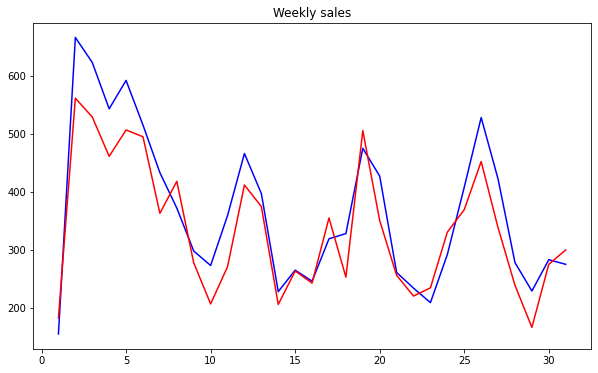

In [27]:
x=[]
predicted_count= X_test
predicted_count['item_cnt']= X_test_pred
# df1 = X_train
# df1 = df1.rename(columns={"date":"date1"})
# df1["date1"] = pd.to_datetime(df1["date1"], format = "%d.%m.%Y")
x = X_test[["d", "item_cnt_day"]].set_index("d").groupby('d').sum()
x1 = predicted_count.drop_duplicates(subset='item_id').set_index("d").groupby('d').sum()
x1= x1[[ "item_cnt"]]# x = X_test[["d", "item_cnt_day"]].set_index("d").groupby('d').sum()
plt.figure(figsize = (10, 6))
plt.plot(x.index, x, color = "blue", label = "Daily sales")
plt.plot(x1.index, x1, color = "red", label = "Daily sales")
plt.title("Weekly sales")


In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sX_train = scaler.fit_transform(X_train)
sX_test= scaler.fit_transform(X_test)

In [29]:
sX_train

array([[-0.59581   ,  0.        ,  0.07276995, ..., -0.05862628,
        -0.54664638,  1.63359726],
       [ 0.72838556,  0.        , -0.19041251, ..., -0.05862628,
         0.33385786, -0.82248193],
       [-0.88074123,  0.        ,  2.04663843, ...,  2.08346193,
        -1.42715061, -0.53353143],
       ...,
       [-1.21039262,  0.        , -1.24314237, ..., -1.26355089,
        -0.54664638,  1.63359726],
       [-0.91444106,  0.        , -0.65098183, ..., -0.46026782,
         1.5078635 ,  0.42963688],
       [ 0.51628428,  0.        ,  2.04663843, ...,  2.08346193,
         0.92086068, -0.62984826]])

In [30]:
y

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
49995    1.0
49996    1.0
49997    1.0
49998    1.0
49999    1.0
Name: item_cnt_month, Length: 50000, dtype: float64

In [32]:
sX_train, sX_test, sy_train, sy_test = train_test_split(train, y, test_size=0.2, random_state=1)
start = time.perf_counter()

smodel = RandomForestRegressor(n_estimators=200, criterion='mae', random_state=3, n_jobs=-1)
smodel.fit(sX_train, sy_train)
# model=pickle.load(open('RandomForestRegressorSalesPredictionModel.sav', 'rb'))
sX_test_pred = smodel.predict(sX_test)
print(mean_absolute_error(sy_test, sX_test_pred))
saccuracy = smodel.score(sX_test, sy_test)
print("Model accuracy: {:.2f}".format(saccuracy))


finish = time.perf_counter()

print(f'Finished in {round(finish-start, 2)} second(s)')

1.5976105
Model accuracy: 0.83
Finished in 3194.17 second(s)


Text(0.5, 1.0, 'Weekly sales')

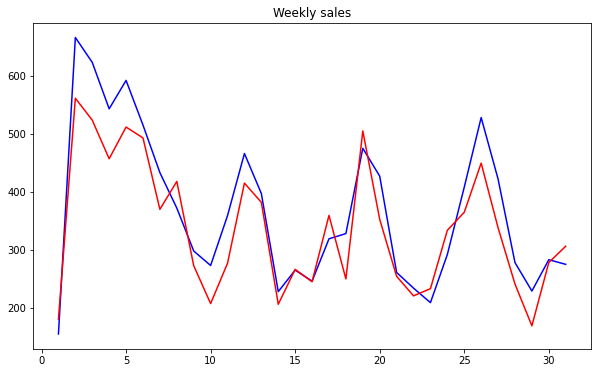

In [33]:
x=[]

spredicted_count= sX_test
spredicted_count['item_cnt']= sX_test_pred
# df1 = X_train
# df1 = df1.rename(columns={"date":"date1"})
# df1["date1"] = pd.to_datetime(df1["date1"], format = "%d.%m.%Y")
sx = X_test[["d", "item_cnt_day"]].set_index("d").groupby('d').sum()
sx1 = spredicted_count.drop_duplicates(subset='item_id').set_index("d").groupby('d').sum()
sx1= sx1[[ "item_cnt"]]# x = X_test[["d", "item_cnt_day"]].set_index("d").groupby('d').sum()
plt.figure(figsize = (10, 6))
plt.plot(sx.index, sx, color = "blue", label = "Daily sales")
plt.plot(sx1.index, sx1, color = "red", label = "Daily sales")
plt.title("Weekly sales")

In [34]:
from sklearn.metrics import r2_score, max_error, mean_squared_error
print(r2_score(y_test, X_test_pred))
print(max_error(y_test, X_test_pred))
print(mean_squared_error(y_test, X_test_pred))


0.831264796622103
141.09
12.9042849625


In [35]:
rms = mean_squared_error(y_test, X_test_pred, squared=False)
rms

3.5922534657927465